In [17]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=569)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [ ]:
import pprint

In [8]:
arxiv.invoke("Data Science")

'Published: 2024-02-14\nTitle: A framework for understanding data science\nAuthors: Michael L Brodie\nSummary: The objective of this research is to provide a framework with which the data\nscience community can understand, define, and develop data science as a field\nof inquiry. The framework is based on the classical reference framework\n(axiology, ontology, epistemology, methodology) used for 200 years to define\nknowledge discovery paradigms and disciplines in the humanities, sciences,\nalgorithms, and now data science. I augmented it for automated problem-solving\nwith'

In [11]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)


In [14]:
from pprint import pprint

result = wiki.invoke("Mughal Empire")
pprint(result)   # much nicer formatting in terminal


('Page: Mughal Empire\n'
 'Summary: The Mughal Empire was an early modern empire in South Asia. At its '
 'peak, the empire stretched from the outer fringes of the Indus River Basin '
 'in the west, northern Afghanistan in the northwest, and Kashmir in the '
 'north, to the highlands of present-day Assam and Bangladesh in the east, and '
 'the uplands of the Deccan Plateau in South India.\n'
 'The Mughal Empire is conventionally said to have been founded in 1526 by '
 'Babur, a ruler from what is today Uzbekistan, who employed aid from the '
 'neighboring Safavid and Ottoman Empires to defeat the sultan of Delhi, '
 'Ibrahim Lodi, in the First Battle of Panipat and to sweep down the plains of '
 'North India. The Mughal imperial structure, however, is sometimes dated to '
 "1600, to the rule of Babur's grandson, Akbar. This imperial structure lasted "
 'until 1720, shortly after the death of the last major emperor, Aurangzeb, '
 'during whose reign the empire also achieved its maximum 

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
 
tavily = TavilySearchResults()



C:\Users\Admin\AppData\Local\Temp\ipykernel_19780\1698117632.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [22]:
result=tavily.invoke("Provide me current AI news")
pprint(result) 

[{'content': '### With an Intel recovery underway, all eyes turn to its '
             'foundry business\n'
             '\n'
             '### OpenAI buys Sky, an AI interface for Mac\n'
             '\n'
             'Turbo AI founders\n'
             '\n'
             '### 20-year-old dropouts built AI notetaker Turbo AI and grew it '
             'to 5 million users\n'
             '\n'
             'Instagram Stories\n'
             '\n'
             '### Instagram users can now use Meta AI editing tools directly '
             'in IG Stories\n'
             '\n'
             '### Two days after OpenAI’s Atlas, Microsoft relaunches a nearly '
             'identical AI browser\n'
             '\n'
             '### Microsoft’s Mico is a ‘Clippy’ for the AI era [...] Contact '
             'Us\n'
             '\n'
             '# AI\n'
             '\n'
             'News coverage on artificial intelligence and machine learning '
             'tech, the companies building them, and

In [23]:
### combine all the tools in a lis

tools=[arxiv,wiki,tavily]

In [25]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

In [26]:

from langchain_core.messages import AIMessage, HumanMessage
result=llm_with_tools.invoke([HumanMessage(content=f"Hey,What is the recent AI news")])

result.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (t588cvhtk)
 Call ID: t588cvhtk
  Args:
    query: recent AI news


In [ ]:
# All Imports
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from IPython.display import Image , display
from langgraph.graph import StateGraph , START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages


In [29]:
## State
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

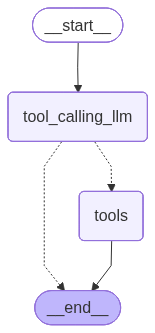

In [32]:
### Entire Chat bot with langraph


### Node Definition
def tool_calling_llm(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}



builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm);
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message (result) from the assistant is a tool -> toold_condition routes to tools
    #If the latest message (result) from the assistant is not a tool -> toold_condition routes to End
    tools_condition
)
builder.add_edge("tools",END)




graph=builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))



In [33]:
messages=graph.invoke({"messages": [HumanMessage(content="What is attention is all you need")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (rbpjjwwg9)
 Call ID: rbpjjwwg9
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper a


In [35]:
messages=graph.invoke({"messages": [HumanMessage(content="Provide me the top 10 recent AI news")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1g2n052pp)
 Call ID: 1g2n052pp
  Args:
    query: top 10 recent AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The Latest AI News & Breakthroughs (Updated Weekly)", "url": "https://binaryverseai.com/ai-news/", "content": "July 19 to July 26, 2025\n\nYour weekly briefing on the top AI news July 26 2025. This issue covers Trump’s new AI executive orders, DeepMind’s Aeneas for archaeology, advances in surgical robotics, and generative AI in fashion.\n\nJuly 26, 2025 Roundup\n\nMay 3–10, 2025  \nAI Advancements, Claude Web Search, Singing Cats & More\n\nMay 10–17, 2025  \nAI Advancements, self-inventing algorithms to robots & More\n\nMay 17–24, 2025  \nLatest AI Tec

In [36]:
messages=graph.invoke({"messages": [HumanMessage(content="Tell me about the Mauryan Empire")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me about the Mauryan Empire
================================== Ai Message ==================================

The Mauryan Empire was a significant ancient Indian empire that existed from approximately 322 BCE to 185 BCE. Here are key details about it:

1. **Founding**: Established by **Chandragupta Maurya**, who overthrew the Nanda dynasty, marking the beginning of the Mauryan rule. His mentor, **Kautilya** (Chanakya), played a crucial role in his rise.

2. **Territory**: At its peak, it covered most of the Indian subcontinent, from present-day Afghanistan to Bangladesh. The capital was **Pataliputra** (modern Patna, India).

3. **Key Rulers**:
   - **Chandragupta Maurya**: Founder, known for consolidating a vast empire.
   - **Bindusara**: His son, who expanded the empire further.
   - **Ashoka the Great**: His grandson, who transformed the empire by promoting **Buddhism** after the Kalinga War (262